## Load libraries

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', -1) 
 
# Matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline

### Define some standard terms, so that columns are consistent
This is all done in __[markdown](https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed)__, taking advantage of __[MathJax](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html)__

In [2]:
p = '$p$ / kPa'
T = '$T$ / K'
xC3 = '$x_{\mathrm{C}_3\mathrm{H}_8}$'  # Here, we've used the notation that x = liquid, y = vapor
yC3 = '$y_{\mathrm{C}_3\mathrm{H}_8}$'  # This nomenclature is not consistent across disciplines.
rho = '$\\rho$ / $\mathrm{kg}\\cdot\mathrm{m}^{-3}$'
Vfrac = '$V_\mathrm{L} / V$'

source = 'Source'
rejected = 'Rejected?'
smoothed = 'Smoothed?'
comment = 'Comment'

## Read in Data and Examine

In [3]:
xl = pd.ExcelFile('H2S-C3H8-data.xlsx')
pdd = {}
plot_kw = {}
for name in xl.sheet_names:
    pdd[name] = xl.parse(name,skiprows=2)
    if 'COMMENT' in pdd[name].columns:
        pdd[name] = pdd[name].rename(columns={'COMMENT':comment})
    if 'Smoothed data?' in pdd[name].columns:
        pdd[name] = pdd[name].rename(columns={'Smoothed data?':smoothed})
    if 'Set' in pdd[name].columns:
        pdd[name] = pdd[name].rename(columns={'Set':rejected})
    for col in (smoothed, rejected):
        if col in pdd[name].columns:
             pdd[name][col] = ~pdd[name][col].isnull();
    print(name)
    print(pdd[name].head())

    for src in pdd[name][source]:
        plot_kw[src] = {}

azeotropic P
   #        Source  Rejected?  Smoothed?  Temperature / K  \
0  1  1950 ram & 0  False      True       280.979           
1  2  1950 ram & 0  False      True       297.636           
2  3  1950 ram & 0  False      True       310.242           
3  4  1950 ram & 0  False      True       320.683           
4  5  1950 ram & 0  False      True       329.569           

   Azeotropic pressure/ kPa Comment  
0  1378.95                   NaN     
1  2068.43                   NaN     
2  2757.90                   NaN     
3  3447.38                   NaN     
4  4136.85                   NaN     
x azeotrope
   #        Source  Rejected?  Smoothed?  Temperature / K  \
0  1  1950 ram & 0  False      True       280.979           
1  2  1950 ram & 0  False      True       297.636           
2  3  1950 ram & 0  False      True       310.242           
3  4  1950 ram & 0  False      True       320.683           
4  5  1950 ram & 0  False      True       329.569           

   Azeotropic

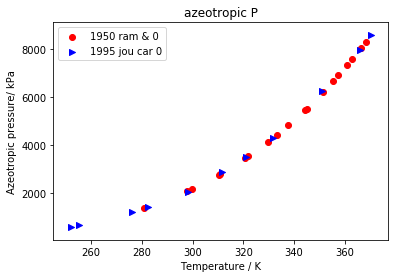

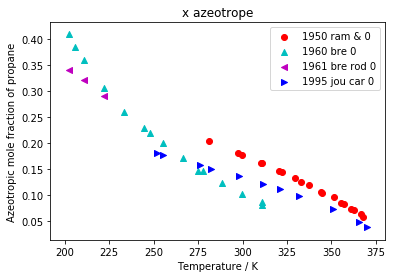

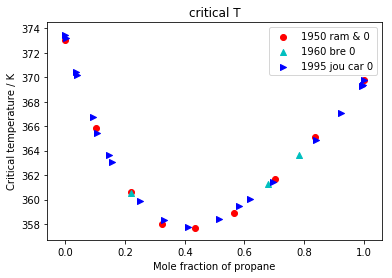

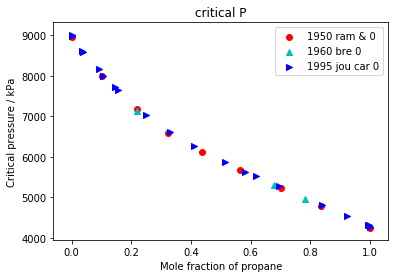

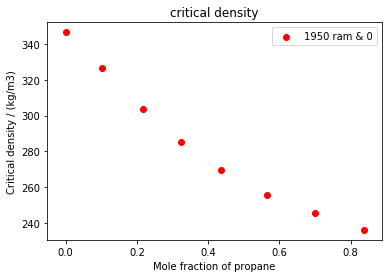

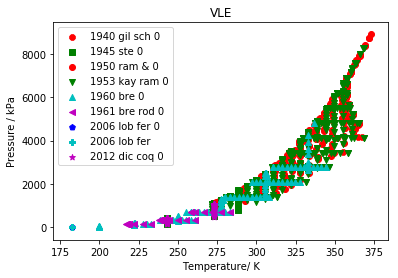

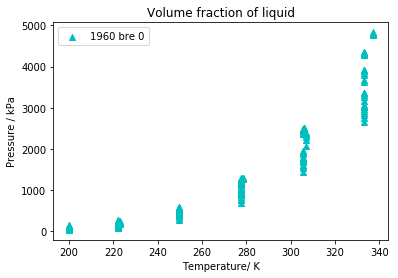

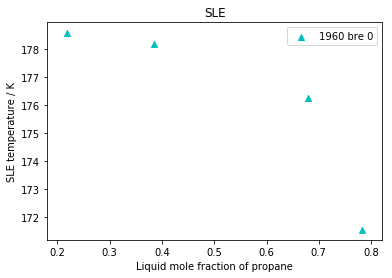

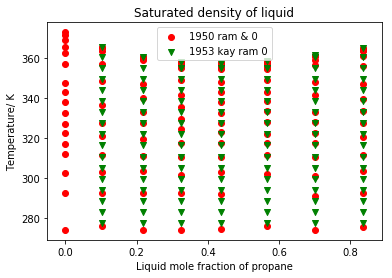

In [4]:
markers = ['o', 'v', '>', '^', '<', '8', 's', 'p', 'P', '*', 'h', 'H', 'x', 'D']
colors  = ['r', 'g', 'b', 'c', 'm']
for (i, src) in zip (np.arange(0,len(plot_kw)), plot_kw):
    plot_kw[src]['c'] = colors[i % len(colors)]
    plot_kw[src]['marker'] = markers[i % len(markers)]
    plot_kw[src]['label'] = src

plots = [['azeotropic P', 'Temperature / K', 'Azeotropic pressure/ kPa'],
         ['x azeotrope',  'Temperature / K', 'Azeotropic mole fraction of propane'],    
         ['critical T',  'Mole fraction of propane', 'Critical temperature / K'],    
         ['critical P',  'Mole fraction of propane', 'Critical pressure / kPa'],    
         ['critical density',  'Mole fraction of propane', 'Critical density / (kg/m3)'],    
         ['VLE',  'Temperature/ K', 'Pressure / kPa'],    
         ['Volume fraction of liquid',  'Temperature/ K', 'Pressure / kPa'],    
         ['SLE',  'Liquid mole fraction of propane', 'SLE temperature / K'],    
         ['Saturated density of liquid',  'Liquid mole fraction of propane', 'Temperature/ K'],    
        ]

def plot_set(df, x=None, y=None, title=None, axes=None):
    if not x:
        x = df.columns[0]
    if not y:
        y = df.columns[1]
    
    if not axes:
        plt.subplots(1,1)
        axes = plt.subplot(1,1,1)

    for src in df[source].unique():
        mask = (df[source]==src) & (df[x].notnull()) & (df[y].notnull())
        if rejected in df.columns:
            mask &= ~df[rejected].astype(bool)
        if len(df[[x,y]][mask]) == 0:
            continue
        if 'marker' in plot_kw[src]:
            axes.scatter(df[x][mask],
                         df[y][mask],
                         **plot_kw[src]
                    )
        else:
            axes.plot(df[x][mask],
                      df[y][mask],
                      **plot_kw[src]
                    )
    
    if title:
        axes.set_title(title)
    axes.set_xlabel(x)
    axes.set_ylabel(y)
    axes.legend()

for (title, x, y) in plots:
    plot_set(pdd[title], x, y, title)

### Format and plot azeotrope data

In [5]:
az_df = pdd['azeotropic P'].drop(columns='#').merge(pdd['x azeotrope'].drop(columns='#'),how='outer')
az_df = az_df.rename(columns={'Temperature / K':T,
                              'Azeotropic pressure/ kPa':p,
                              'Azeotropic mole fraction of propane':xC3})
az_df = az_df[az_df.columns[[0,3,4,6,1,2,5]]]

def color_row(row, color='LightCoral', field=rejected, value=True):
    '''
    Reformat a row based upon certain values.
    '''
    attr = 'color: {}'.format(color)
    return [attr if row[field] == value else ''] * len(row)

def color_nan(value, color='lightgray'):
    '''
    Reformat a cell based upon a certain value.
    '''
    attr = 'color: {}'.format(color)
    return attr if type(value) == float and np.isnan(value) else ''

az_df.style.apply(color_row, axis=1). \
            applymap(color_nan).      \
            format({T: '{:0.2f}',p: '{:0.4g}',xC3: '{:0.3f}'})

,Source,$T$ / K,$p$ / kPa,$x_{\mathrm{C}_3\mathrm{H}_8}$,Rejected?,Smoothed?,Comment
0,1950 ram & 0,280.98,1379,0.203,False,True,nan
1,1950 ram & 0,297.64,2068,0.180,False,True,nan
2,1950 ram & 0,310.24,2758,0.161,False,True,nan
3,1950 ram & 0,320.68,3447,0.145,False,True,nan
4,1950 ram & 0,329.57,4137,0.132,False,True,nan
5,1950 ram & 0,337.57,4826,0.119,False,True,nan
6,1950 ram & 0,344.90,5516,0.102,False,True,nan
7,1950 ram & 0,351.35,6205,0.096,False,True,nan
8,1950 ram & 0,357.40,6895,0.082,False,True,nan
9,1950 ram & 0,362.90,7584,0.070,False,True,nan


C:\Users\kennethk\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\kennethk\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


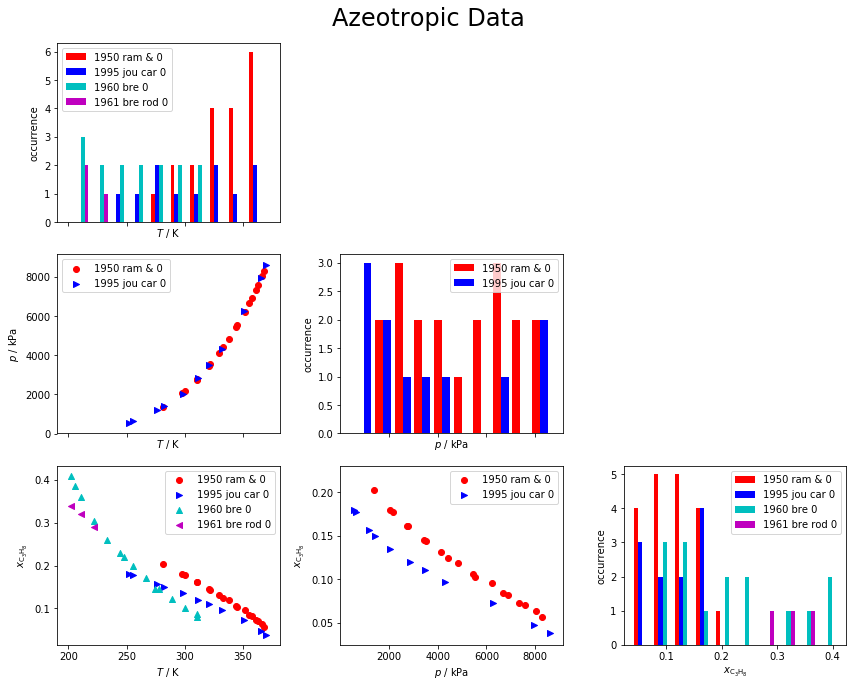

In [6]:
def hist_set(df, prop=None, title=None, axes=None):
    if not prop:
        prop = df.columns[0]
    
    if not axes:
        plt.subplots(1,1)
        axes = plt.subplot(1,1,1)

    sources = df[source].unique()
    x = pd.DataFrame()
    for src in sources:
        mask = df[source]==src
        if rejected in df.columns:
            mask &= ~df[rejected].astype(bool)
        target = df[prop][mask].dropna()
        if len(target) == 0 or 'marker' not in plot_kw[src]:
            sources = np.delete(sources, np.where(sources == src), axis=0)
            continue
        x = pd.concat([x, target], ignore_index=True, axis=1)
    
    axes.hist(x.transpose(), color=list(map(lambda src: plot_kw[src]['c'], sources)), label=sources)
    
    if title:
        axes.set_title(title)
    axes.set_xlabel(prop)
    axes.set_ylabel("occurrence")
    axes.legend()

def plot_grid(df, columns, title=None):
    n = len(columns)
    fig, axes = plt.subplots(n,n, figsize=(12, 10), sharex='col')
    for i in np.arange(n):
        for j in np.arange(n):
            if (i < j):
                axes[i,j].axis('off')
                continue
            if (i == j):
                hist_set(df, columns[i], axes=axes[i,i])
            else:
                plot_set(df, columns[j], columns[i], axes=axes[i,j])
    if title:
        fig.suptitle(title, fontsize=24)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# np.warnings.filterwarnings('ignore')
plot_grid(az_df, az_df.columns[[1,2,3]], title='Azeotropic Data')

In [7]:
# And generate a classic Arrhenius plot while we are at it


### Format and plot critical data

In [8]:
crit_df = pdd['critical T'].drop(columns='#').merge(pdd['critical P'].drop(columns='#'),how='outer')  \
          .merge(pdd['critical density'].drop(columns='#'),how='outer')
crit_df = crit_df.rename(columns={'Mole fraction of propane':xC3,
                                  'Critical temperature / K':T,
                                  'Critical pressure / kPa':p,
                                  'Critical density / (kg/m3)':rho})
crit_df = crit_df[crit_df.columns[[0,2,3,5,6,1,4]]]
crit_df.style.apply(color_row, axis=1).                             \
              applymap(color_nan).                                  \
              set_properties(subset=[rho], **{'width': '8em'}).     \
              format({T: '{:0.2f}',p: '{:0.4g}',xC3: '{:0.3f}', rho: '{:0.2f}'})

,Source,$x_{\mathrm{C}_3\mathrm{H}_8}$,$T$ / K,$p$ / kPa,$\rho$ / $\mathrm{kg}\cdot\mathrm{m}^{-3}$,Rejected?,Comment
0,1950 ram & 0,0.000,373.05,8943,346.48,False,nan
1,1950 ram & 0,0.102,365.87,7994,326.78,False,nan
2,1950 ram & 0,0.218,360.59,7172,303.55,False,nan
3,1950 ram & 0,0.325,358.02,6593,285.13,False,nan
4,1950 ram & 0,0.436,357.71,6120,269.91,False,nan
5,1950 ram & 0,0.566,358.87,5665,255.66,False,nan
6,1950 ram & 0,0.701,361.65,5234,245.88,False,nan
7,1950 ram & 0,0.837,365.15,4792,236.27,False,nan
8,1950 ram & 0,1.000,369.79,4249,nan,False,nan
9,1953 kay ram 0,0.000,373.05,8943,346.48,True,Duplicate of 1950 ram 0 (dissertation) - exact match


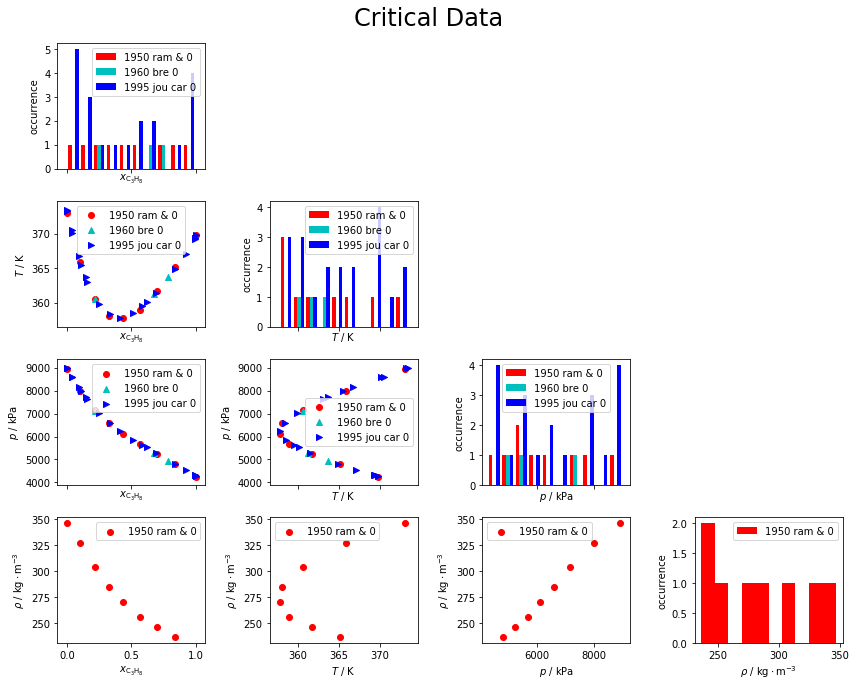

In [9]:
plot_grid(crit_df, crit_df.columns[[1,2,3,4]], title='Critical Data')

### Vapor-Liquid Equilibrium

## REFPROP
Using the variable `run_refprop`, this worksheet will swap between running the program and using a pickle of the results so that users w/o a license or install have an opportunity to see the comparisons.  We take advantage of the wrappers available at https://github.com/usnistgov/REFPROP-wrappers, installable with the command:
```
pip install ctREFPROP
```

C:\Users\kennethk\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\kennethk\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


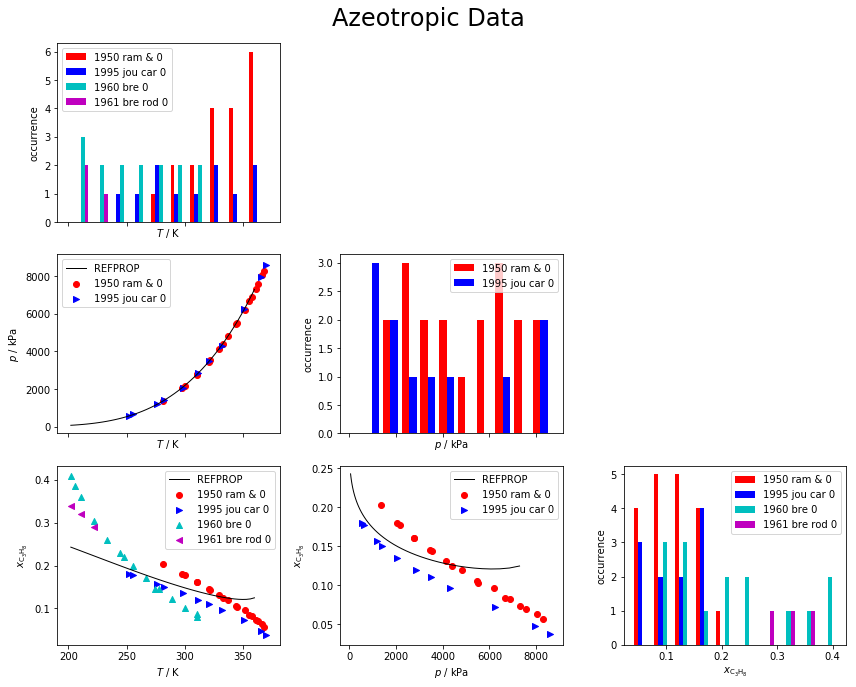

In [10]:
run_refprop = True
REFPROP_src = 'REFPROP'
plot_kw[REFPROP_src] = {'lw': 1, 'c': 'k', 'label': REFPROP_src}

if run_refprop:
    from ctREFPROP.ctREFPROP import REFPROPFunctionLibrary
    root = r'C:\Program Files (x86)\REFPROP' # Default install directory; customize as necessary <--------
    RP = REFPROPFunctionLibrary(root)
    MOLAR_BASE_SI = RP.GETENUMdll(0,'MOLAR BASE SI').iEnum
    RP.SETPATHdll(root)
else:
    import pickle as pkl
    

from scipy import optimize
def azeo_dev(z0, temp):
    return  RP.REFPROPdll('PROPANE;H2S','TQ','P',MOLAR_BASE_SI,0,0,temp,1,[z0,1-z0]+[0.0]*18).x[0] - \
            RP.REFPROPdll('PROPANE;H2S','TQ','P',MOLAR_BASE_SI,0,0,temp,0,[z0,1-z0]+[0.0]*18).y[0]

az_df = az_df[az_df.Source != REFPROP_src]
z = optimize.brentq(azeo_dev,0.01,.99, args=(200))
for temp in np.linspace(az_df[T].min(),az_df[T].max()):
    z = optimize.brentq(azeo_dev,0.85*z,1.20*z, args=(temp))
    ref = RP.REFPROPdll('PROPANE;H2S','TQ','P',MOLAR_BASE_SI,0,0,temp,1,[z,1-z]+[0.0]*18)
    if ref.ierr != 0:
        continue
    press = ref.Output[0] / 1000
    az_df.loc[len(az_df)] = {source:REFPROP_src, rejected: False, smoothed: True, T: temp, p: press, comment: np.nan, xC3:z}

plot_grid(az_df, az_df.columns[[1,2,3]], title='Azeotropic Data')

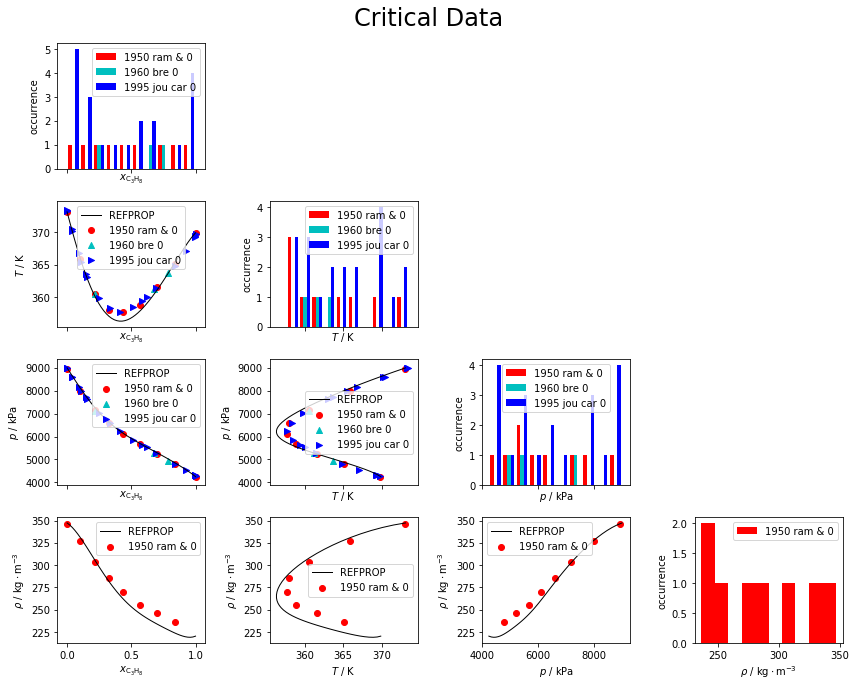

In [11]:
crit_df = crit_df[crit_df.Source != REFPROP_src]
for z in np.linspace(0,1):
    ref = RP.REFPROPdll('PROPANE;H2S','CRIT','T,P,D,M',MOLAR_BASE_SI,0,0,0,0,[z,1-z]+[0.0]*18)
    if ref.ierr > 0:
        continue
    press = ref.Output[0] / 1000
    crit_df.loc[len(crit_df)] = {source:REFPROP_src, 
                                 rejected: False, 
                                 T: ref.Output[0], 
                                 p: ref.Output[1]/1000,
                                 rho: ref.Output[2]*ref.Output[3],
                                 comment: np.nan, 
                                 xC3:z}

plot_grid(crit_df, crit_df.columns[[1,2,3,4]], title='Critical Data')

In [12]:
RP.REFPROPdll('PROPANE;H2S','CRIT','T,P,D,M',MOLAR_BASE_SI,0,0,0,0,[z,1-z]+[0.0]*18)

REFPROPdlloutput(z=array('d', [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), Output=array('d', [369.89, 4251158.396288677, 5000.0, 0.044095619999999995, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0, -9999990.0,

In [13]:
crit_df

,Source,$x_{\mathrm{C}_3\mathrm{H}_8}$,$T$ / K,$p$ / kPa,$\rho$ / $\mathrm{kg}\cdot\mathrm{m}^{-3}$,Rejected?,Comment
0,1950 ram & 0,0.000000,373.046000,8943.190000,346.479000,False,NaN
1,1950 ram & 0,0.101600,365.868000,7994.470000,326.777000,False,NaN
2,1950 ram & 0,0.218300,360.590000,7171.930000,303.550000,False,NaN
3,1950 ram & 0,0.324500,358.017000,6592.770000,285.129000,False,NaN
4,1950 ram & 0,0.435900,357.712000,6119.790000,269.911000,False,NaN
5,1950 ram & 0,0.565800,358.867000,5665.420000,255.655000,False,NaN
6,1950 ram & 0,0.701400,361.651000,5234.500000,245.883000,False,NaN
7,1950 ram & 0,0.836700,365.151000,4791.860000,236.272000,False,NaN
8,1950 ram & 0,1.000000,369.790000,4249.240000,NaN,False,NaN
9,1953 kay ram 0,0.000000,373.046000,8943.190000,346.479000,True,Duplicate of 1950 ram 0 (dissertation) - exact match


In [14]:
plot_kw[REFPROP_src]

{'lw': 1, 'c': 'k', 'label': 'REFPROP'}